# 构建一个基于 SQL 数据的问答系统

:::info 先决条件

本指南假设您熟悉以下概念：

- [聊天模型](/docs/concepts/chat_models)
- [工具](/docs/concepts/tools)
- [代理](/docs/concepts/agents)
- [LangGraph](/docs/concepts/architecture/#langgraph)

:::

让 LLM 系统查询结构化数据与查询非结构化文本数据在质上有所不同。在后者中，通常是生成可以在向量数据库中搜索的文本，而对于结构化数据，通常是让 LLM 使用 SQL 等 DSL 编写和执行查询。在本指南中，我们将介绍使用[链式](/docs/tutorials/sql_qa#chains)和[代理](/docs/tutorials/sql_qa#agents)来创建基于数据库表格数据的问答系统的基本方法。这些系统将允许我们询问有关数据库中数据的问题并得到自然语言的答复。两者的主要区别在于我们的代理可以根据需要多次循环查询数据库以回答问题。

## ⚠️ 安全说明 ⚠️

构建 SQL 数据库的问答系统需要执行模型生成的 SQL 查询。这样做存在固有的风险。确保您的数据库连接权限始终严格限制在链/代理的需求范围内。这将减轻但不会消除构建模型驱动系统的风险。有关一般安全最佳实践的更多信息，[请参见此处](/docs/security)。


## 架构

在高层面上，这些系统的步骤是：

1. **将问题转换为 SQL 查询**：模型将用户输入转换为 SQL 查询。
2. **执行 SQL 查询**：执行查询。
3. **回答问题**：模型使用查询结果响应用户输入。

注意，查询 CSV 数据也可以遵循类似的方法。有关对 CSV 数据进行问答的更多详细信息，请参见我们的[操作指南](/docs/how_to/sql_csv)。

![sql_usecase.png](../../static/img/sql_usecase.png)

## 设置

首先，获取所需包并设置环境变量：

In [ ]:
%%capture --no-stderr
%pip install --upgrade --quiet langchain-community langchainhub langgraph

```python
# 注释下面的代码以选择退出在此笔记本中使用 LangSmith。这不是必需的。
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
    os.environ["LANGSMITH_TRACING"] = "true"
```

### 示例数据

下面的示例将使用带有 Chinook 数据库的 SQLite 连接，这是一个代表数字媒体商店的示例数据库。按照[这些安装步骤](https://database.guide/2-sample-databases-sqlite/)在与此笔记本相同的目录中创建 `Chinook.db`。您还可以通过命令行下载和构建数据库：
```bash
curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db
```

现在，`Chinook.db` 在我们的目录中，我们可以使用由 SQLAlchemy 驱动的 `SQLDatabase` 类与其交互：

In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

很好！我们有了一个可以查询的 SQL 数据库。现在让我们尝试将它连接到 LLM。

## 链式系统 {#chains}

链是可预测步骤的组合。在 [LangGraph](/docs/concepts/architecture/#langgraph) 中，我们可以通过简单的节点序列来表示一个链。让我们创建一个步骤序列，给定一个问题，执行以下操作：
- 将问题转换为 SQL 查询；
- 执行查询；
- 使用结果回答原始问题。

这种架构不支持某些场景。例如，该系统会对任何用户输入执行 SQL 查询 —— 即使是"hello"。重要的是，正如我们将在下面看到的，有些问题需要多个查询才能回答。我们将在代理部分解决这些场景。

### 应用状态

LangGraph 的[状态](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)控制输入到应用程序的数据，在步骤之间传输的数据，以及应用程序输出的数据。它通常是一个 `TypedDict`，但也可以是 [Pydantic BaseModel](https://langchain-ai.github.io/langgraph/how-tos/state-model/)。

对于这个应用程序，我们只需要跟踪输入问题、生成的查询、查询结果和生成的答案：

In [ ]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str  # 问题
    query: str    # 查询
    result: str   # 结果
    answer: str   # 答案

现在我们只需要定义在这个状态上操作并填充其内容的函数。

### 将问题转换为 SQL 查询

第一步是接收用户输入并将其转换为 SQL 查询。为了可靠地获得 SQL 查询（不包含 markdown 格式和解释或说明），我们将使用 LangChain 的[结构化输出](/docs/concepts/structured_outputs/)抽象。

让我们为应用程序选择一个聊天模型：

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />


In [ ]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4", temperature=0)

我们将从 [Prompt Hub](https://smith.langchain.com/hub) 获取一个提示模板来指导模型。

In [5]:
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 2
for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}
================================ Human Message =================================

Question: {input}


该提示模板包含几个我们需要填充的参数，如 SQL 方言和表结构。LangChain 的 [SQLDatabase](https://python.langchain.com/api_reference/community/utilities/langchain_community.utilities.sql_database.SQLDatabase.html) 对象包含了帮助处理这些参数的方法。我们的 `write_query` 步骤将只填充这些参数并提示模型生成 SQL 查询：

In [6]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

让我们测试一下：

In [7]:
write_query({"question": "How many Employees are there?"})

{'query': 'SELECT COUNT(*) as employee_count FROM Employee;'}

### 执行查询

**这是创建 SQL 链中最危险的部分。** 请仔细考虑是否可以在您的数据上运行自动查询。尽可能最小化数据库连接权限。考虑在查询执行前添加人工审核步骤（见下文）。

要执行查询，我们将从 [langchain-community](/docs/concepts/architecture/#langchain-community) 加载一个工具。我们的 `execute_query` 节点将只是包装这个工具：

In [8]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

测试这个步骤：

In [9]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})

{'result': '[(8,)]'}

### 生成答案

最后，我们的最后一个步骤使用从数据库中获取的信息来生成问题的答案：

In [10]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

### 使用 LangGraph 进行编排

最后，我们将我们的应用程序编译成一个单一的 `graph` 对象。在这种情况下，我们只是将三个步骤连接成一个序列。

In [11]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

LangGraph 还提供了内置的实用工具来可视化应用程序的控制流：

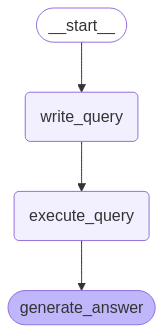

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

让我们测试我们的应用程序！注意，我们可以流式输出各个步骤的结果：

In [13]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) as employee_count FROM Employee;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees in total.'}}


查看 [LangSmith 追踪](https://smith.langchain.com/public/30a79380-6ba6-46af-8bd9-5d1df0b9ccca/r)。

## 代理系统 {#agents}

链式方法的主要限制是它的固定模式。例如，回答某些问题可能需要多个查询。对此，我们可以使用代理。

代理是一个循环系统，它可以：
1. 规划下一步行动
2. 执行该行动
3. 观察结果
4. 重复，直到完成任务

我们可以使用与上面相同的步骤和工具，但现在我们将允许代理根据需要多次执行它们。这里的关键见解是代理系统经常以某种形式包含循环。

### 代理状态

我们的代理状态将包括与链一样的信息，外加一个跟踪之前查询的列表和一个标记系统是否完成任务的标志：

首先让我们设置代理的状态管理：

In [ ]:
from typing import List, Tuple

class AgentState(TypedDict):
    """代理的状态。"""

    # 输入/输出
    question: str
    answer: str | None

    # 内部状态
    past_queries: List[Tuple[str, str]]  # [(query, result), ...]
    is_done: bool

### 代理节点

与链式系统不同，我们的代理需要决定采取什么行动。让我们用 LangChain 的[结构化输出](/docs/concepts/structured_outputs/)创建一个函数来做这个决定：

In [ ]:
from typing_extensions import Annotated
from enum import Enum


class Action(str, Enum):
    """代理可以执行的动作。"""

    QUERY = "QUERY"  # 执行一个新的 SQL 查询
    FINISH = "FINISH"  # 完成并提供答案


class Plan(TypedDict):
    """代理的计划。"""

    action: Annotated[Action, "下一个要执行的动作"]
    query: Annotated[str | None, "如果动作是 QUERY，则需要执行的 SQL 查询"]
    answer: Annotated[str | None, "如果动作是 FINISH，则给出的答案"]


def plan(state: AgentState):
    """规划下一步行动。"""
    # 创建格式化的历史查询
    if state["past_queries"]:
        history = "\n".join(
            [
                f"Query: {query}\nResult: {result}"
                for query, result in state["past_queries"]
            ]
        )
        history = f"已执行的查询：\n{history}"
    else:
        history = "尚未执行任何查询。"

    # 提示 LLM 计划下一步行动
    prompt = (
        "您是一个负责回答有关 SQL 数据库问题的代理。"",
        "您可以选择执行新的查询或给出最终答案。"",
        "以下是相关上下文：\n"",
        f"问题: {state['question']}\n"
        f"数据库信息: {db.get_table_info()}\n"
        f"数据库方言: {db.dialect}\n"
        f"{history}"
    )

    structured_llm = llm.with_structured_output(Plan)
    result = structured_llm.invoke(prompt)

    # 返回动作及其相关数据
    return result

### 代理编排

现在我们可以将代理编排为一个带有循环的图。每当调用 `plan` 节点时，它都会返回一个动作（`QUERY` 或 `FINISH`），然后是要采取的相应步骤。这里展示了如何使用 LangGraph 构建这样的流程：

In [ ]:
from langgraph.graph import END, Graph, StateGraph
from typing import Annotated, Callable, TypeVar

S = TypeVar("S", bound=AgentState)

def create_graph() -> Graph[S]:
    """创建代理的循环控制流。"""
    # 创建图
    graph_builder = StateGraph(AgentState)

    # 创建各个节点
    def execute(state: AgentState):
        """执行查询并保存结果。"""
        execute_query_tool = QuerySQLDatabaseTool(db=db)
        result = execute_query_tool.invoke(state["next_query"])
        return {
            "past_queries": state["past_queries"] + [(state["next_query"], result)]
        }

    def decide_next(state: AgentState):
        """决定下一步操作。"""
        next_plan = plan(state)
        match next_plan["action"]:
            case Action.QUERY:
                return (
                    "execute",
                    {"next_query": next_plan["query"]},
                )
            case Action.FINISH:
                return (
                    END,
                    {"is_done": True, "answer": next_plan["answer"]},
                )

    # 添加节点到图中
    graph_builder.add_node("plan", decide_next)
    graph_builder.add_node("execute", execute)

    # 设置边，创建循环
    graph_builder.add_edge("execute", "plan")
    graph_builder.add_edge(START, "plan")

    # 编译
    return graph_builder.compile()


graph = create_graph()

让我们可视化这个流程图：

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

最后，让我们使用这个代理回答一个需要多个查询的问题：

In [ ]:
for step in graph.stream(
    {
        "question": "谁管理的员工最多？",
        "past_queries": [],
        "is_done": False,
        "answer": None,
    },
    stream_mode="updates",
):
    print(step)

## 人工审核

对于需要人工审核链的用例，您可以设置一个需要人工批准的环境变量，并使用 [human_approval_stage](/docs/expression_language/how_to/human_approval) 在执行代理的查询之前获取批准。

## 总结

我们探讨了两种架构来构建 SQL 数据库的问答系统：链式和代理。链式是一种简单的方法，可以将问题直接转换为 SQL 查询并获得答案。代理则提供了更大的灵活性，可以根据需要执行多个查询来回答问题。

作为参考，您可以在 [LangSmith](https://smith.langchain.com/public/30a79380-6ba6-46af-8bd9-5d1df0b9ccca/r) 中查看这些系统在操作中的表现。